In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import Abdullatif Koksal's Word Embbeddings

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.optim as optim
import torch.nn as nn
from IPython import display


from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('trmodel', binary=True)
type(word_vectors)


gensim.models.keyedvectors.KeyedVectors

In [3]:
indexedwords=word_vectors.index_to_key
#print(words)

vectors_array = np.zeros((len(word_vectors), word_vectors.vector_size))
for i, word in enumerate(word_vectors.index_to_key):
   # print(word, word_vectors[word])
    vectors_array[i] = word_vectors[word]

# Now vectors_array contains the vectors for each word
print(len(vectors_array))



412457


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
print(type(vectors_array))
vectors_array.shape

<class 'numpy.ndarray'>


(412457, 400)

## Prepare the AutoEncoder

Train an AutoEncoder to reduce dimensions from 400 to 40.

Methods used:

- Use Dropout to avoid overfitting
- Implement 3 layers so model can better **understand**
- **Tanh** activation function
- **Min max scaling** for output normalization

In [6]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, n_features, n_hidden):
        super(AE, self).__init__()
        # Encoder layers
        self.encoder_layer1 = nn.Linear(n_features, 200)
        self.encoder_layer2 = nn.Linear(200, 100)
        self.encoder_layer3 = nn.Linear(200, n_hidden)

        # Decoder layers
        self.decoder_layer1 = nn.Linear(n_hidden, 200)
        self.decoder_layer2 = nn.Linear(100, 200)
        self.decoder_layer3 = nn.Linear(200, n_features)

        self.activation = nn.Tanh()
        self.output_activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)

    def min_max_scaling(self, x, min_val, max_val):
        # Scale values between -1 and 1
        scaled = -2 + 4 * (x - min_val) / (max_val - min_val)
        return scaled

    def encode(self, x):
        # Apply min-max scaling to input x


        x = self.activation(self.encoder_layer1(x))
        x = self.dropout(x)
        # x_scaled = self.activation(self.encoder_layer2(x_scaled))
        # x_scaled = self.dropout(x_scaled)
        encoded = self.activation(self.encoder_layer3(x))
        return encoded

    def decode(self, x):
        x = self.activation(self.decoder_layer1(x))
        x = self.dropout(x)
        # x = self.activation(self.decoder_layer2(x))
        # x = self.dropout(x)
        decoded = self.output_activation(self.decoder_layer3(x))

        # Apply min-max scaling to normalize the output between -1 and 1
        decoded_min = decoded.min(dim=1, keepdim=True)[0]
        decoded_max = decoded.max(dim=1, keepdim=True)[0]
        decoded_normalized = self.min_max_scaling(decoded, decoded_min, decoded_max)

        return decoded_normalized

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


## Train the AutoEncoder

- Learning rate = 0.001
- Adam optimizer
- MSE Loss
- Epoch count = 50

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

x_train_tensor = torch.from_numpy(vectors_array).float()
x_train_tensor = (x_train_tensor / np.linalg.norm(x_train_tensor, axis=-1, keepdims=True)).to(device)
y_train_tensor = torch.from_numpy(vectors_array).float()
y_train_tensor = (y_train_tensor / np.linalg.norm(y_train_tensor, axis=-1, keepdims=True)).to(device)

# training and testing, if needed
train_ratio = 1
train_size = int(train_ratio * len(x_train_tensor))
test_size = len(x_train_tensor) - train_size

# Use random_split to create training and testing datasets
train_dataset, test_dataset = random_split(x_train_tensor, [train_size, test_size])

# Create DataLoader for training and testing datasets if needed
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

learning_rate = 1e-3 # alpha

ae = AE(400, 40)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ae.to(device)

criterion = nn.MSELoss() # (x-y)^2
optimizer = torch.optim.Adam(ae.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-8)
n_epoch = 50
losses = []

In [8]:
for epoch in range(n_epoch):
    running_loss = 0.0
    for data in train_loader:
        inputs = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ae(inputs)
        loss = criterion(outputs, inputs)  # MSE loss between input and reconstructed output

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{n_epoch}], Loss: {running_loss / len(train_loader)}")

Epoch [1/50], Loss: 0.03438488381080533
Epoch [2/50], Loss: 0.021828769574464106
Epoch [3/50], Loss: 0.02154461402566202
Epoch [4/50], Loss: 0.021388700892848354
Epoch [5/50], Loss: 0.02128502552769616
Epoch [6/50], Loss: 0.021211861524148556
Epoch [7/50], Loss: 0.02116045076168944
Epoch [8/50], Loss: 0.021122778384546487
Epoch [9/50], Loss: 0.021094689746537516
Epoch [10/50], Loss: 0.021071341891701404
Epoch [11/50], Loss: 0.021053776704237123
Epoch [12/50], Loss: 0.021039367281362673
Epoch [13/50], Loss: 0.021028671857367082
Epoch [14/50], Loss: 0.0210208453274986
Epoch [15/50], Loss: 0.021014836605259265
Epoch [16/50], Loss: 0.021008941800178725
Epoch [17/50], Loss: 0.021005799674958213
Epoch [18/50], Loss: 0.021003205832972126
Epoch [19/50], Loss: 0.021001704402323396
Epoch [20/50], Loss: 0.02100253682444912
Epoch [21/50], Loss: 0.020999335676949313
Epoch [22/50], Loss: 0.02099829608985863
Epoch [23/50], Loss: 0.020997596992452447
Epoch [24/50], Loss: 0.020997730885671622
Epoch [25

## Measure the AutoEncoder Performance

First we pick random words (e.g. 10) and calculate the cosine similarity between each one of them.

So for a list of `['elma', 'armut', 'portakal']` we will have:
  
*   `cosine_similarity('elma', 'armut') `

*   `cosine_similarity('elma', 'portakal') `

*   `cosine_similarity('armut', 'portakal')`

We do this to have different cosine similarity performances between random samples. We do this calculation for both **original vectors (with dimension 400)** and the **encoded vectors (with dimension 40)**, adding them to `original_cos_similarities` and `encoded_cos_similarities`.

In [15]:
import random
ae.eval()
subset_words = random.sample(list(word_vectors.index_to_key), 15)

subset_words = ['elma', 'armut', 'süt', 'şeker', 'tuz', 'karabiber', 
                'köpek', 'sosyoloji', 'keser', 'kıyma', 'dana', 'pelerin']


word_embeddings_400d = [word_vectors[word] for word in subset_words]

word_embeddings_400d = torch.tensor(word_embeddings_400d, dtype=torch.float32)

# Encode all word embeddings using the autoencoder
encoded_word_embeddings = []
for embedding in word_embeddings_400d:
    embedding = embedding.unsqueeze(0).cuda()
    with torch.no_grad():
      encoded_embedding = ae.encode(embedding)
    encoded_word_embeddings.append(encoded_embedding.squeeze(0))

encoded_word_embeddings = torch.stack(encoded_word_embeddings)

# Compare original cosi and embedded cosi
original_cos_similarities = []
encoded_cos_similarities = []
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
for i in range(len(subset_words)):
    for j in range(i + 1, len(subset_words)):
        original_similarity = cosi(word_embeddings_400d[i].unsqueeze(0), word_embeddings_400d[j].unsqueeze(0)).item()
        original_cos_similarities.append(original_similarity)

        encoded_similarity = cosi(encoded_word_embeddings[i].unsqueeze(0), encoded_word_embeddings[j].unsqueeze(0)).item()
        encoded_cos_similarities.append(encoded_similarity)


We will then check the **mean cos similarities** for both of the cos similarities (encoded and original).   What we want to see is how big the difference is.

In [10]:

original_cos_similarities = np.array(original_cos_similarities)
encoded_cos_similarities = np.array(encoded_cos_similarities)
mean_original_similarity = np.mean(original_cos_similarities)
mean_encoded_similarity = np.mean(encoded_cos_similarities)
print(f"Mean cosine similarity in original embeddings: {mean_original_similarity}")
print(f"Mean cosine similarity in encoded embeddings: {mean_encoded_similarity}")

Mean cosine similarity in original embeddings: 0.2833993759175593
Mean cosine similarity in encoded embeddings: 0.37002125698508637


Finaly we will plot how the different word

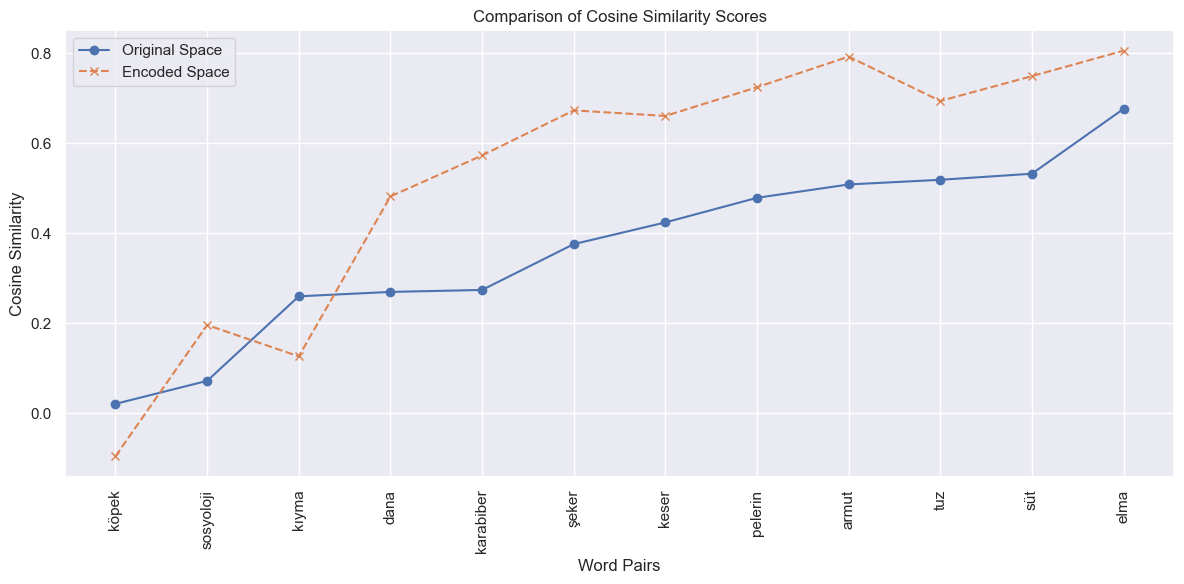

In [11]:
import matplotlib.pyplot as plt


sorted_data = sorted(zip(subset_words, original_cos_similarities, encoded_cos_similarities), key=lambda x: x[1])
sorted_word_pairs, sorted_original_cos_similarities, sorted_encoded_cos_similarities = zip(*sorted_data)

plt.figure(figsize=(12, 6))
plt.plot(sorted_original_cos_similarities, label='Original Space', marker='o', linestyle='-')
plt.plot(sorted_encoded_cos_similarities, label='Encoded Space', marker='x', linestyle='--')

plt.title('Comparison of Cosine Similarity Scores')
plt.xlabel('Word Pairs')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)

plt.xticks(ticks=np.arange(len(sorted_word_pairs)), labels=[f"{pair}" for pair in sorted_word_pairs], rotation=90)
plt.tight_layout()

plt.show()


In [12]:

word1 = (torch.tensor(word_vectors['toz'], device="cuda")).unsqueeze(0)
word2 =(torch.tensor(word_vectors['araba'], device="cuda")).unsqueeze(0)
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
output = cosi(word1, word2)
print("Cosine Similarity of high dimension embeddings", output.item() )



testembedding = ae.encode(word1)
testembedding2 = ae.encode(word2)
# print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of low dim embeddings", output.item() )


Cosine Similarity of high dimension embeddings 0.22464922070503235
Cosine Similarity of low dim embeddings 0.4267613887786865


In [13]:
print(device)

cuda


In [16]:
# torch.save(ae, '/content/drive/MyDrive/autoencodermodel.pt')

In [17]:
# model = torch.load('/content/drive/MyDrive/autoencodermodel.pt')

In [19]:
# model.parameters()

We save the encoded 40 dimension tensors at `lower_dimension_embedding`

In [20]:
lower_dimension_embeddings = ae.encode(x_train_tensor)
print("Lower Dimension Embeddings Shape : ", lower_dimension_embeddings.shape)


Lower Dimension Embeddings Shape :  torch.Size([412457, 40])


## Preprocess Fine Tuning Data

Now we have the lower dimension encodings ready, we will download a dataset containing turkish food recipes and apply preprocessing on them.

In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ozans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [78]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("mertbozkurt/llama2-TR-recipe")


Found cached dataset json (C:/Users/ozans/.cache/huggingface/datasets/mertbozkurt___json/mertbozkurt--llama2-TR-recipe-67222f093b729982/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]


Remove punctuations, HTML tags, stopwords and numeric values

We used nltk to detect stopwords.

In [79]:
import string
from nltk.corpus import stopwords
import re

regular_punct = list(string.punctuation)

def remove_punctuation(text,punct_list):
  for punc in punct_list:
      if punc in text:
          text = text.replace(punc, ' ')
  return text.strip()


stopWords = set(stopwords.words('turkish'))
wordsFiltered = []
numerics_removed_words = []
embedding_test = []
counter = 0
for text_dict in dataset["train"]:
  text = text_dict["text"]
  text = re.sub(r'\[[^\]]*\]','', text)
  clean_text = remove_punctuation(text, regular_punct)
  words = word_tokenize(clean_text.lower())
  for w in words:
      if w in stopWords:
          continue
      elif not w.isnumeric():
        numerics_removed_words.append(w)
        if counter < 100:
          embedding_test.append(w)
        counter += 1

In this step we will detect the new unique words in the dataset (the ones which didn't exist in the previous embeddings), and initialize random embeddings for these new words.

We can see in this cell that there is over 4500 new words

In [80]:
setindextedword = set(indexedwords)
new_words = set(numerics_removed_words)
difference = list(new_words.difference(setindextedword))
print(len(difference))

0


In [25]:
randomembeddings = np.random.rand(len(difference), 40)

copystore = np.copy(lower_dimension_embeddings.cpu().detach().numpy())
for word in difference:
  indexedwords.append(word)

 # lower_dimension_embeddings = np.concatenate((lower_dimension_embeddings, np.random.rand(40)), axis=0)

# We add the random embeddings on top of the copystore which holds the
# 40 dimension embeddings, trained by the AutoEncoder
copystore = np.vstack([copystore, randomembeddings])

In [26]:
print( len(indexedwords), len(copystore))

417056 417056


## Fine Tune New Embeddings with the New Dataset

We will use Word2Vec model to train our new 40 dimension embeddings, with the dataset we added.

In [54]:
#fine tune embeddings with new dataset

import pandas as pd

id2tok = dict(enumerate(indexedwords))
tok2id = {token: id for id, token in id2tok.items()}

data = {'input1': [], 'input2': [], 'output': []}

reverse_data = {'input1': [], 'input2': [], 'output': []}
numerics_removed_words

for i in range(len(numerics_removed_words)-1):
  data['input1'].append(numerics_removed_words[i])
  data['input2'].append(numerics_removed_words[i+1])
  data['output'].append(1)

for i in range(len(numerics_removed_words)-1,1,-1):
  reverse_data['input1'].append(numerics_removed_words[i])
  reverse_data['input2'].append(numerics_removed_words[i-1])
  reverse_data['output'].append(1)

df_data = pd.DataFrame(data)
df_reverse = pd.DataFrame(reverse_data)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

print("tok2idget",tok2id.get)
class data_set(Dataset):
  def __init__(self, data):
    self.X = np.vectorize(tok2id.get)(data[:,:-1])
    self.y = data[:,-1]
  def __len__(self):
    return len(self.X)
  def getx(self):
    return self.X
  def __getitem__(self, index):
    return self.X[index], self.y[index]


trainset = data_set(pd.concat([df_data, df_reverse], ignore_index=True).values)

tok2idget <built-in method get of dict object at 0x000002264C94AF00>


We define the Word2Vec Model

In [55]:
class Word2Vec2(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(copystore), freeze=False)
    self.embedding.requires_grad = True

  def forward(self, X_batch):
    U = self.embedding(X_batch[:,0])
    V = self.embedding(X_batch[:,1])

    output = torch.sigmoid(torch.sum(torch.mul(U, V), 1))
    return output



In [56]:
len(torch.FloatTensor(copystore))

417056

Load the data to DataLoader

In [57]:
import torch.utils.data as data_utils


#indices = torch.arange(len(trainset)/10)
#subset = data_utils.Subset(trainset, indices)

dataloader = DataLoader(trainset, 1024, shuffle=True)

for i, (batch_X, batch_y) in enumerate(dataloader):
  print(i, batch_X[:,0],batch_X[:,1], batch_y)
  if i >= 2:
    break

0 tensor([ 32713,   1220,    620,  ..., 219686,  10893,    620],
       dtype=torch.int32) tensor([ 1720,  1976, 18611,  ..., 10439,   731,   209], dtype=torch.int32) tensor([1, 1, 1,  ..., 1, 1, 1])
1 tensor([207230, 188669,   4517,  ...,  28508, 413301,   2862],
       dtype=torch.int32) tensor([104647,    118,  34160,  ...,    243, 416571,    172],
       dtype=torch.int32) tensor([1, 1, 1,  ..., 1, 1, 1])
2 tensor([248561,      2,   2862,  ..., 416271, 412466,  32713],
       dtype=torch.int32) tensor([68410,  4753, 40272,  ..., 40606,    41,  3292], dtype=torch.int32) tensor([1, 1, 1,  ..., 1, 1, 1])


In [58]:
type(torch.FloatTensor(vectors_array))

torch.Tensor

## Train Word2Vec Model

Hyperparameters used:
- BCE Loss
- Adam optimizer
- epoch count = 200
- Learning Rate = 0.01

In [60]:
from itertools import chain
from collections import Counter


model = Word2Vec2()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 1e-2
EPOCHS = 200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

from tqdm import tqdm # For progress bars
from IPython import display

running_loss = []
for epoch in tqdm(range(EPOCHS)):
  epoch_loss = 0
  for i, (batch_X, batch_y) in enumerate(dataloader):
    optimizer.zero_grad()
    # X_batch is (i,j) index must be int
    X_batch = batch_X.type(torch.int).to(device)
    # y_batch must be float
    y_batch = batch_y.type(torch.float32).to(device)
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    epoch_loss += loss.item()
    # loss.requires_grad = True
    loss.backward()
    optimizer.step()
  epoch_loss /= len(dataloader)
  running_loss.append(epoch_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')
  display.clear_output(wait=True)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [53:40<00:00, 16.10s/it]


In [61]:
# torch.save(model, '/content/drive/MyDrive/word2vecmodel.pt')

## Test the New Model

In [126]:
test_embeddings = [
    ['biber', 'dolması'], ['dana', 'kıyma'], ['trakya', 'kapama'], ['fırında', 'kuzu'], ['nohut', 'yemeği'],
    ['soslu', 'tavuk'], ['toz', 'şeker'], ['cevizli', 'kek'], ['tuz', 'kimyon'], ['tuz', 'karabiber'],
    ['tas', 'kebabı'], ['diş', 'sarımsak'], ['toz', 'şeker'], ['diş', 'sarımsak'], ['taze', 'soğan'],
    ['irmik', 'helvası'], ['sıvı', 'yağ'], ['bitter', 'çikolata'], ['bulgur', 'çorbası'], ['domates', 'çorbası'],
    ['kırmızı', 'lahana'], ['bulgur', 'köfte'], ['süzme', 'yoğurt'], ['ton', 'balık'], ['kuskus', 'salata'],
    ['deniz', 'börülce'], ['ramazan', 'pide'], ['ekmek', 'kızartma'], ['patates', 'kızartma'], ['peynirli', 'acuka'],
    ['yufka', 'börek'], ['çöp', 'şiş'], ['tencere', 'kapağı'], ['izmir', 'köfte'], ['taze', 'fasulye'],
    ['kapuska', 'yemek'], ['brüksel', 'lahana'], ['kabaklı', 'mücver'], ['ıspanak', 'yemek'], ['galeta', 'unu'],
    ['elma', 'dilim'], ['patlıcan', 'kızartma'], ['kabak', 'musakka'], ['sebze', 'kızartma'], ['sıcak', 'su'],
    ['kuru', 'fasulye'], ['kızgın', 'yağ'], ['şark', 'köfte'], ['patates', 'püresi'], ['çerkez', 'çorba'],
    ['bardakta', 'tiramisu'], ['kağıt', 'kebabı'], ['etli', 'patlıcan'], ['isveç', 'köftesi'], ['çiğ', 'köfte'],
    ['bal', 'kabağı'], ['kuru', 'üzüm'], ['mısır', 'un'], ['ayva', 'tatlı'], ['vanilya', 'süt'], ['ıslak', 'kek'],
    ['kuru', 'baklava'], ['tahin', 'pekmez'], ['ekmek', 'kadayıfı'], ['çilekli', 'parfe'], ['antep', 'fıstıklı'],
    ['tavuk', 'yemeği'], ['arpacık', 'soğan'], ['kuyruk', 'yağı'], ['dolmalık', 'biber'], ['sucuklu', 'yumurta'],
    ['nasıl', 'yapılır'], ['çökertme', 'kebabı'], ['tavuk', 'baget'], ['gerekli', 'malzemeler'], ['iç', 'pilav'],
    ['jülyen', 'doğrama'], ['ince', 'doğranmış'], ['kremalı', 'mantarlı'], ['kültür', 'mantar'], ['kaşar', 'peyniri'],
    ['sürekli', 'karıştırarak'], ['küçük', 'kap'], ['kavrulmuş', 'kıyma'], ['yelpaze', 'karnabahar'],
    ['zeytinyağlı', 'enginar'], ['servis', 'edebilirsiniz'], ['etli', 'patates'], ['büyük', 'boy'],
    ['kereviz', 'yemeği'], ['acur', 'turşusu'], ['sıcak', 'suyla'], ['ince', 'doğranmış'], ['iyice', 'karıştırın'],
    ['tel', 'çırpıcı'], ['limon', 'suyu'], ['ceviz', 'içi'], ['bıçak', 'yardımı'], ['orta', 'kalınlık'],
    ['çoban', 'salatası'], ['bir', 'tutam'],
]

len(test_embeddings)

101

In [160]:

from IPython.display import display, HTML

df = pd.DataFrame(columns=['words', 'old embedding', 'new embedding', 'difference'])

In [161]:
df = df.iloc[0:0]
for words in test_embeddings:
    testembedding = None
    testembedding2 = None
    word1 = (torch.tensor(word_vectors[words[0]], device="cuda"))
    word2 =(torch.tensor(word_vectors[words[1]], device="cuda"))
    
    testembedding = model.embedding(torch.tensor((tok2id.get(words[0])), device="cuda"))
    testembedding2 = model.embedding(torch.tensor((tok2id.get(words[1])), device="cuda"))

    cosi = torch.nn.CosineSimilarity(dim=0)
    output = cosi(testembedding, testembedding2)
    # print("Cosine Similarity of trained low dim embeddings ",output.item() )
    
   
    
    oldembedding = None
    oldembedding2 = None
    oldembedding =  ae.encode(word1)
    oldembedding2 = ae.encode(word2)
    output2 = cosi(oldembedding, oldembedding2)
    # print("Cosine Similarity of low dimension embeddings ",output2.item() )
    
    row_df = pd.DataFrame([[f"{words[0]} - {words[1]}", output2.item(), output.item(), (output.item() - output2.item()) ]], columns=df.columns)
    df = pd.concat([df, row_df], ignore_index=True)
    
display(df)
# Use for bigger display
# print(df.to_markdown())

,words,old embedding,new embedding,difference
0,biber - dolması,0.778299,0.968511,0.190211
1,dana - kıyma,0.223975,0.969887,0.745912
2,trakya - kapama,0.323684,0.985542,0.661858
3,fırında - kuzu,0.620381,0.962910,0.342528
4,nohut - yemeği,0.482932,0.930481,0.447549
...,...,...,...,...
96,ceviz - içi,0.447627,0.941644,0.494017
97,bıçak - yardımı,0.242267,0.985671,0.743404
98,orta - kalınlık,0.374974,0.945748,0.570775
99,çoban - salatası,0.465882,0.970214,0.504332


In [170]:
# Use this to sample some data to use for visualization
df_sample = df.sample(n=21).reset_index(drop=True)

# df_sample = df
df_sample

,words,old embedding,new embedding,difference
0,kültür - mantar,0.484111,0.919738,0.435626
1,toz - şeker,0.640335,0.984014,0.343678
2,nohut - yemeği,0.482932,0.930481,0.447549
3,çerkez - çorba,0.444581,0.909890,0.465309
4,kereviz - yemeği,0.487920,0.959985,0.472065
5,soslu - tavuk,0.856671,0.978945,0.122274
6,ramazan - pide,0.585773,0.923388,0.337615
7,ince - doğranmış,0.654579,0.968218,0.313640
8,bıçak - yardımı,0.242267,0.985671,0.743404
9,acur - turşusu,0.763976,0.949926,0.185949


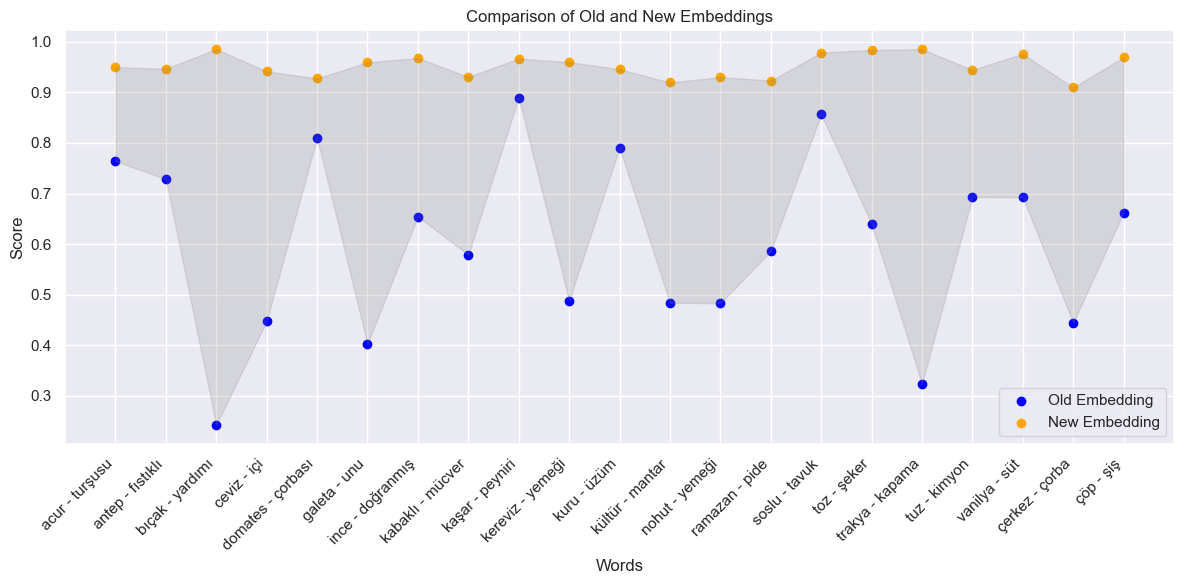

In [180]:
df_sorted = df_sample.sort_values(by='words')

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(df_sorted['words'], df_sorted['old embedding'], color='blue', label='Old Embedding')
plt.scatter(df_sorted['words'], df_sorted['new embedding'], color='orange', label='New Embedding')

# Fill the gap between old and new embeddings in gray
plt.fill_between(df_sorted['words'], df_sorted['old embedding'], df_sorted['new embedding'], color='gray', alpha=0.2)

# Displaying words for some data points
for i, word in enumerate(df_sorted['words']):
    if word in ['word1', 'word2', 'word3']:
        plt.text(df_sorted['words'][i], df_sorted['old embedding'][i], word, fontsize=8, ha='right')
        plt.text(df_sorted['words'][i], df_sorted['new embedding'][i], word, fontsize=8, ha='right')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding labels and title
plt.xlabel('Words')
plt.ylabel('Score')
plt.title('Comparison of Old and New Embeddings')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

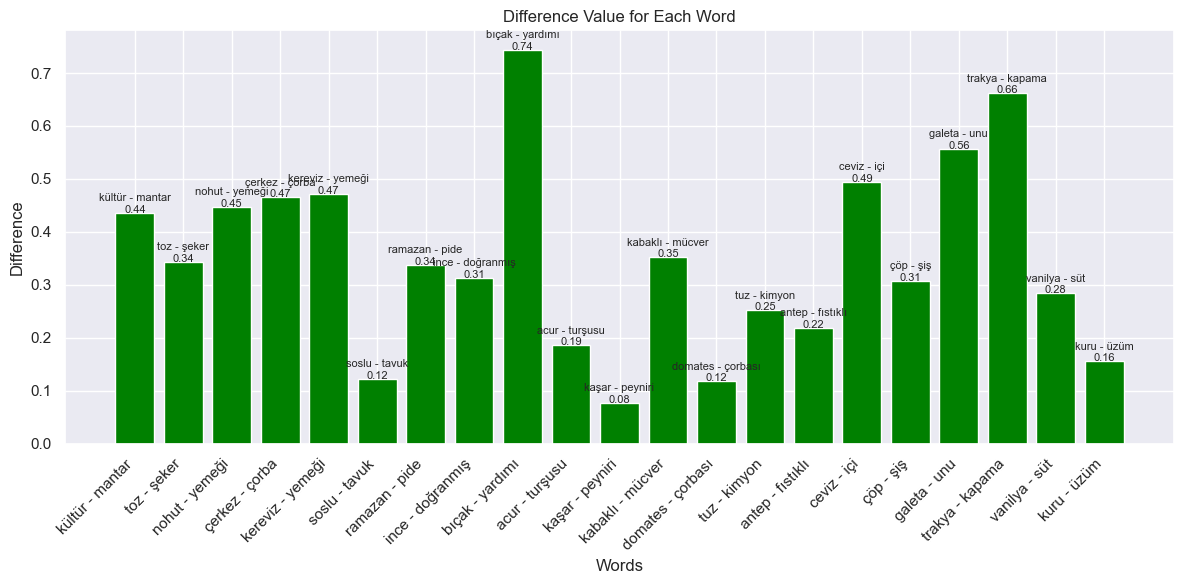

In [181]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df_sample['words'], df_sample['difference'], color='green')

# Displaying words for some data points
for i, word in enumerate(df_sample['words']):
    
    if i == len(df['words']):
        break
    plt.text(df_sample['words'][i], df_sample['difference'][i], f"{word}\n{df_sample['difference'][i]:.2f}", fontsize=8, ha='center')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding labels and title
plt.xlabel('Words')
plt.ylabel('Difference')
plt.title('Difference Value for Each Word')

# Display the plot
plt.tight_layout()
plt.show()